In [ ]:
!pip install -q ray[RLlib]

In [ ]:
# Borrow some boilerplate code from an earlier implementation. The interesting stuff is all in this notebook
!git clone https://github.com/MatthewCWeston/RLlib_TicTacToe_League

# Environment Code

In [ ]:
# @title TicTacToe Env (Parallel)
import gymnasium as gym
from gymnasium.spaces import Box, Discrete

from ray.rllib.env.multi_agent_env import MultiAgentEnv
from ray.rllib.utils.test_utils import (
    add_rllib_example_script_args,
)

import numpy as np

#from algo.constants import ACTION_MASK, OBSERVATIONS

TTT_WIN_PATHS = np.array([
    [0,1,2],[3,4,5],[6,7,8], # Horizontal
    [0,3,6],[1,4,7],[2,5,8], # Vertical
    [0,4,8],[2,4,6]          # Diagonal
])

class TicTacToe(MultiAgentEnv):
    def __init__(self, config=None):
        super().__init__()
        self.agents = self.possible_agents = ['X','O']
        #"""
        space = gym.spaces.Dict({
            ACTION_MASK: Box(0.0, 1.0, shape=(10,)), # Action 9 is NOP
            OBSERVATIONS: Box(0.0, 1.0, (18,), np.float32)
        })
        self.observation_spaces = {
            'X': space,
            'O': space,
        }
        self.action_spaces = {
            'X': Discrete(10),
            'O': Discrete(10),
        }
        self.board = None
        self.current_player = None
    def get_obs(self):
        board = self.board.copy()
        am = np.zeros((10,))
        am[:9] += 1-board.sum(axis=0)
        am_inactive = np.zeros((10,))
        am_inactive[9] = 1
        obs = {
            'X': {
                OBSERVATIONS: board.flatten(),
                ACTION_MASK: am_inactive,
            },
            'O': {
                OBSERVATIONS: board[::-1].flatten(),
                ACTION_MASK: am_inactive,
            },
        }
        obs[self.current_player][ACTION_MASK] = am
        return obs
    def reset(self, *, seed=None, options=None):
        self.board = np.zeros((2,9), dtype=np.float32)
        self.current_player = 'X'
        return self.get_obs(), {}
    def step(self, action_dict):
        action = action_dict[self.current_player]
        rewards = {'X': 0.0, 'O': 0.0}
        terminateds = {"__all__": False}
        opponent = 'X' if self.current_player=='O' else 'O'
        # The current player will always see himself as the first row and his opponent as the second row
        board_ix = 0 if self.current_player=='X' else 1
        if (action!=9): # Env checker ignores action mask; must check this.
          self.board[board_ix][action] = 1
        board = self.board[board_ix]
        win_val = [1, 1, 1]
        for p in TTT_WIN_PATHS:
            if (board[p].sum()==3):
                rewards[self.current_player] = 1.0
                rewards[opponent] = -1.0
                # Episode is done and needs to be reset for a new game.
                terminateds["__all__"] = True
        # The board might also be full w/o any player having won/lost.
        if (self.board.sum()==9) and (terminateds["__all__"]==False):
            terminateds["__all__"] = True
        #display_board(self.board)
        self.current_player = opponent
        obs = self.get_obs()
        return (
            obs,
            rewards,
            terminateds,
            {},
            {},
        )

def display_board(board):
  board = board.reshape((2,9))
  moves = []
  for x, o in zip(board[0], board[1]):
    if (x):
      moves.append('X')
    elif (o):
      moves.append('O')
    else:
      moves.append('_')
  print(moves[:3])
  print(moves[3:6])
  print(moves[6:])
  print('-----')

def convert_board(s):
  s = s.replace('\n','')
  board = np.zeros((2,9))
  for i, c in enumerate(s):
    if (c=='X'):
      board[0][i] = 1
    elif (c=='O'):
      board[1][i] = 1
  return board



In [ ]:
# @title eval_model
def query_agent_2(obs_array, agent):
  obs_array = obs_array.T
  if (not isinstance(agent, torch.nn.Module)): # Heuristic, for testing
    action = agent.forward_inference({Columns.OBS: torch.tensor(obs_array.flatten()).unsqueeze(0)})['actions'][0]
    return int(action)
  obs = {}
  obs[OBSERVATIONS] = torch.tensor(obs_array).float().flatten()
  am = torch.zeros(10)
  am[:9] = torch.tensor(-obs_array.sum(axis=0)+1.).float().flatten()
  obs[ACTION_MASK] = am
  logits = agent.forward_inference({Columns.OBS: obs})['action_dist_inputs']
  action = logits.argmax() # deterministic
  return action.item()

class BoardState():
    '''
      The 'opponent' is always [1], the agent is always [0].
    '''
    def __init__(self, state, prev=None, winner=-1):
      self.state=state
      self.prev=prev
      self.winner=winner
    def check_win(self, player):
      b = self.state[:,player]
      for p in TTT_WIN_PATHS:
        if (b[p].sum()==3):
          return True
      return False
    def propose(self, opponent_model):
      next_states = []
      occupied = self.state.sum(axis=1)
      for i in range(9):
        if occupied[i]==1:
          continue
        s = self.state.copy()
        s[i][1] = 1
        if (self.check_win(1)): # Did the model lose?
          next_states.append(BoardState(s, prev=self, winner=1))
          continue
        if (s.sum() == 9):
          continue # board is full
        try:
          act = query_agent_2(s, opponent_model)
        except Exception as e:
          print(s)
          raise Exception()
        s[act][0] = 1
        if (self.check_win(0)): # Did the model win?
          next_states.append(BoardState(s, prev=self, winner=0))
          continue
        next_states.append(BoardState(s, prev=self))
      return next_states

def eval_model(model):
  winners = {0:[],1:[]}
  model_first = np.zeros((9,2))
  model_first[query_agent_2(model_first, model)][0] = 1
  opponent_first = np.zeros((9,2))
  boards_to_process = [BoardState(opponent_first), BoardState(model_first)]
  max_sum = 0
  while len(boards_to_process) > 0:
    b = boards_to_process[0]
    if (b.winner != -1):
      winners[b.winner].append(b)
    else:
      boards_to_process.extend(b.propose(model))
    del boards_to_process[0]

  for i in range(2):
    print(f'Winner: {i} count: {len(winners[i])}')
  return [len(winners[i]) for i in [0,1]]

# Main Code

### Initialize

In [ ]:
%cd RLlib_TicTacToe_League

/content/RLlib_TicTacToe_League


In [ ]:
# @title Imports
import numpy as np
import functools

from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.core.rl_module.multi_rl_module import MultiRLModuleSpec
from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.algorithms.ppo.torch.default_ppo_torch_rl_module import DefaultPPOTorchRLModule

from ray.rllib.examples.rl_modules.classes.action_masking_rlm import (
    ActionMaskingTorchRLModule,
)

from classes.heuristics import RandHeuristicRLM, BlockWinHeuristicRLM, PerfectHeuristicRLM
from ray.rllib.utils.metrics import (
    TRAINING_ITERATION_TIMER,
)

from ray.rllib.utils.metrics import ENV_RUNNER_RESULTS, EVALUATION_RESULTS

2026-02-04 10:43:50,131	WARNING ppo_torch_rl_module.py:8 -- DeprecationWarning: `ray.rllib.algorithms.ppo.torch.ppo_torch_rl_module.PPOTorchRLModule` has been deprecated. Use `ray.rllib.algorithms.ppo.torch.default_ppo_torch_rl_module.DefaultPPOTorchRLModule` instead. This will raise an error in the future!


# Code

In [ ]:
# @title Match Generation

# Get the agent that will be learning this episode, from the set of learning agents
def get_learning_agent(episode, policies_to_train):
  # Returns the agent (X or O) and the ID of the 'student' policy
  len_policies = len(policies_to_train)
  eid = hash(episode.id_) % (2*len_policies)
  agent_id = "X" if eid < len_policies else "O"
  policy_id = policies_to_train[eid%len_policies]
  return agent_id, policy_id

def pfsp(agent, opponents, wr, rng):
  if ('exploiter' not in agent):
    # Main agents want to not-lose, and want to learn from opponents they lose to.
    weights = np.array([wr[o][agent] for o in opponents])
  else:
    # Exploiter agents want to win, and want to learn from opponents they don't win against
    weights = np.array([(1-wr[agent][o]) for o in opponents])
  wr_sum = weights.sum()
  if (wr_sum == 0):
    return rng.choice(opponents)
  return rng.choice(opponents, p=weights/wr_sum)

def create_atm_fn(policies_to_train, agent_names, wr, just_added):
  def atm_fn(agent_id, episode, **kwargs):
    # The learning agent this episode is 'for', distributed evenly b/t X and O.
    student_agent, student_policy = get_learning_agent(
        episode,
        policies_to_train
    )
    if (agent_id==student_agent):
      return student_policy
    eid = hash(episode.id_)
    rng = np.random.default_rng(seed=abs(eid))
    # Select an opponent.
    if (student_policy=="main"): # opponents for main
      rand = rng.random()
      if (rand < .35): # 35% self play
        return "main"
      elif (rand < .85): # 50% PFSP (any other agent)
        valid_options = filter(lambda s: s!='main', agent_names)
      else: # 15% anything that beats main, SP otherwise
        valid_options =list(filter(lambda s: wr[s]['main'] > wr['main'][s], agent_names))
        if (len(valid_options)==0):
          return "main"
    elif (student_policy[:14] == "main_exploiter"): # opponents for ME
      wr_thresh_me = wr["main"]["main_exploiter"] / 9 # w/w+l >= 10%
      if (wr["main_exploiter"]["main"] > wr_thresh_me):
        return "main" # play versus main, if it's doing passably
      # Otherwise PFSP against main's past copies
      valid_options = filter(lambda s: s[:6] == 'main_v', agent_names)
    else: # opponents for LE (all past players; fig 1)
      valid_options = filter(lambda s: '_v' in s, agent_names)
    # Run PFSP on our options
    valid_options = filter(lambda s: s not in just_added, valid_options)
    return pfsp(student_policy, list(valid_options), wr, rng)
  return atm_fn

In [ ]:
# @title SelfPlayCallback (AlphaStar)
from collections import defaultdict

import numpy as np

from ray.rllib.callbacks.callbacks import RLlibCallback
from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.core.rl_module.multi_rl_module import MultiRLModuleSpec
from ray.rllib.utils.metrics import ENV_RUNNER_RESULTS
from ray.rllib.core import (
    COMPONENT_RL_MODULE,
    COMPONENT_LEARNER,
    COMPONENT_LEARNER_GROUP,
)

def get_mc_string(agent1, agent2):
  return '-'.join(sorted([agent1, agent2]))

class SelfPlayCallback(RLlibCallback):
    def __init__(self, clone_every=10):
        super().__init__()
        self.clone_every = clone_every
        self.league = ['main','main_exploiter','league_exploiter','main_v0']
        self.win_counts = defaultdict(lambda: defaultdict(lambda:0))
        self.match_counts = defaultdict(lambda:0)
        self.version_counter = defaultdict(lambda: 1)
        # prior totals, stored on *learner*
        self.win_counts_total = defaultdict(lambda: defaultdict(lambda:0))
        self.match_counts_total = defaultdict(lambda:0)
        # Hacky fix for newly added agents not working
        self.just_added = []

    def on_episode_end(
        self,
        *,
        episode,
        env_runner,
        metrics_logger,
        env,
        env_index,
        rl_module,
        **kwargs,
    ) -> None:
        x_agent = episode.module_for('X')
        o_agent = episode.module_for('O')
        # Avoid errors due to "complete_episodes" not being enabled
        rewards = episode.get_rewards()
        if ('X' not in rewards or 'O' not in rewards):
          return
        # Update stats
        outcome = np.sign(rewards['X'][-1])
        self.match_counts[get_mc_string(x_agent, o_agent)] += 1
        metrics_logger.log_value(
            f"match_count_{get_mc_string(x_agent,o_agent)}",
            1.0,
            reduce='lifetime_sum'
        )
        if (outcome != 0 and x_agent==o_agent):
          metrics_logger.log_value(
              f"win_count_{x_agent}{x_agent}",
              0.5,
              reduce='lifetime_sum'
          )
        elif (outcome == 1):
          metrics_logger.log_value(
              f"win_count_{x_agent}{o_agent}",
              1.0,
              reduce='lifetime_sum'
          )
        elif (outcome == -1):
          metrics_logger.log_value(
              f"win_count_{o_agent}{x_agent}",
              1.0,
              reduce='lifetime_sum'
          )

    def inherit_stats(self, new_module_id):
        ''' Called on the envrunners; populates their stats for new agents. '''
        to_clone = new_module_id.split('_v')[0]
        # Inherit current agent's win statistics
        for opponent in list(self.win_counts[to_clone].keys()):
          if ('_v' not in opponent): # No reason to track b/t frozen agents
            self.win_counts[new_module_id][opponent] = self.win_counts[to_clone][opponent]
            self.win_counts[opponent][new_module_id] = self.win_counts[opponent][to_clone]
            self.match_counts[get_mc_string(new_module_id, opponent)] = self.match_counts[get_mc_string(to_clone, opponent)]
          # soft reset counts after cloning; fresh start
          if (self.win_counts[to_clone][opponent] > 10):
            self.match_counts[get_mc_string(to_clone, opponent)] /= 10.
            self.win_counts[to_clone][opponent] /= 10.
            if (to_clone!=opponent):
              self.win_counts[opponent][to_clone] /= 10.

    def clone_agent(self, algorithm, to_clone, reset_source=False):
      # Clone an agent
      vid = self.version_counter[to_clone]
      self.version_counter[to_clone] += 1
      new_module_id = f"{to_clone}_v{vid}"
      self.just_added.append(new_module_id)
      for opponent in self.league:
        if (opponent==to_clone):
          continue
      self.league.append(new_module_id)
      print(f"adding new opponent to the mix ({new_module_id}).")
      self.inherit_stats(new_module_id)
      cloned_module = algorithm.get_module(to_clone)
      algorithm.add_module(
          module_id=new_module_id,
          module_spec=RLModuleSpec.from_module(cloned_module),
      )
      module_updates = {new_module_id: cloned_module.get_state(),}
      # update shared critic, syncing weights (get_module only looks at envrunners, can't use)
      sc = algorithm.learner_group._learner._module[SHARED_CRITIC_ID]
      sc.new_agent_embedding(
          name_to_mid(to_clone),
          name_to_mid(new_module_id),
      )
      if (reset_source==True): # reset source agent weights to initial state
        initial_agent = algorithm.learner_group._learner._module['main_v0']
        module_updates[to_clone] = initial_agent.get_state()
        sc.new_agent_embedding( # Reset its embedding, too
            name_to_mid('main_v0'),
            name_to_mid(to_clone),
        )
        self.win_counts[to_clone] = defaultdict(lambda:0)
        self.match_counts[to_clone] = defaultdict(lambda:0)
      # Share out updated shared critic to learners
      module_updates[SHARED_CRITIC_ID] = sc.get_state()
      # Syncs weights across everything (wait, why does it just say 'learner group'?)
      algorithm.set_state(
          {
              COMPONENT_LEARNER_GROUP: {
                  COMPONENT_LEARNER: {
                      COMPONENT_RL_MODULE: module_updates
                  }
              },
          }
      )

    def build_stats_from_results(self, result):
        league_size = len(self.league)
        wrs = defaultdict(lambda:defaultdict(lambda:0))
        new_matches = {} # Just for debugging / observation
        for i in range(league_size-1):
          a = self.league[i]
          for j in range(i, league_size):
            b = self.league[j]
            # Record statistics involving a learning agent
            if (('_v' not in a) or ('_v' not in b)):
              k = get_mc_string(a,b)
              mc_new = result.get(f"match_count_{k}", 0)
              wcab_new = result.get(f"win_count_{a}{b}", 0)
              wcba_new = result.get(f"win_count_{b}{a}", 0)
              new_matches[k] = mc_new - self.match_counts_total[k]
              self.match_counts[k] += new_matches[k]
              self.match_counts_total[k] = mc_new
              self.win_counts[a][b] += wcab_new - self.win_counts_total[a][b]
              self.win_counts_total[a][b] = wcab_new
              if (a!=b): # Don't double-count wins for self-play
                self.win_counts[b][a] += wcba_new - self.win_counts_total[b][a]
                self.win_counts_total[b][a] = wcba_new
              if (self.match_counts[k] != 0):
                #'''# The actual rate of wins
                # Useful for prioritizing threatening opponents, when using p=wr(b,a) rather than p=wr(a,b)*wr(b,a)
                wrs[a][b] = self.win_counts[a][b] / self.match_counts[k]
                wrs[b][a] = self.win_counts[b][a] / self.match_counts[k]
              else:
                wrs[a][b] = wrs[b][a] = 1/3 # Initialize as 33/33/33
        return wrs, new_matches

    def update_atm_fn(self, algorithm, wr):
        # Set new mapping function
        ptt = algorithm.config.policies_to_train.copy()
        ptt.remove(SHARED_CRITIC_ID)
        agent_to_module_mapping_fn = create_atm_fn(ptt, self.league, wr, self.just_added)
        algorithm.config._is_frozen = False
        algorithm.config.multi_agent(policy_mapping_fn=agent_to_module_mapping_fn)
        algorithm.config.freeze()
        # Add to (training) EnvRunners.
        def _add(_env_runner, _module_spec=None):
            _env_runner.config.multi_agent(
                policy_mapping_fn=agent_to_module_mapping_fn,
            )
            return MultiRLModuleSpec.from_module(_env_runner.module)
        algorithm.env_runner_group.foreach_env_runner(_add)

    def on_train_result(self, *, algorithm, metrics_logger=None, result, **kwargs):
        # Rebuild a set of stats with information from our env runners
        wrs, nm = self.build_stats_from_results(result[ENV_RUNNER_RESULTS])
        #
        to_clone = set({})
        reset_clone = defaultdict(lambda:False)
        self.just_added = []
        iter = algorithm.iteration
        print(f"Iter={iter}:")
        print(f"Matchups: {dict(self.match_counts)}")
        print(f"Win rates:")
        #for a, wrd in wrs.items():
        for a in ['main', 'main_exploiter', 'league_exploiter']:
          print(f'\t{a}')
          for o, wr in wrs[a].items():
            new_matches = nm[get_mc_string(a,o)]
            if (new_matches!=0):
              wr_inv = wrs[o][a]
              dw = 1 - wr - wr_inv
              print(f'\t\t{o}: {wr:.02f}-{dw:.02f}-{wr_inv:.02f} (+{new_matches})')
        if (iter)%self.clone_every==0:
          to_clone.add('main')
          to_clone.add('league_exploiter')
          if (iter)%(2*self.clone_every)==0:
            to_clone.add('main_exploiter')
        # Special cloning criteria
        # Main exploiter
        clone_main_exploiter = True
        for o in self.win_counts['main_exploiter'].keys():
          if (o != 'main' and o[:6] != 'main_v'):
            continue # Ignore non-main agents
          if self.win_counts['main_exploiter'][o] < (1./0.7)*self.win_counts[o]['main_exploiter']:
            clone_main_exploiter = False
        if clone_main_exploiter:
          to_clone.add('main_exploiter')
          print('Cloning main exploiter on merit')
        # League exploiter
        le_wc = [self.win_counts['league_exploiter'][o] >= (1./0.7)*self.win_counts[o]['league_exploiter'] for o in self.win_counts['league_exploiter'].keys()]
        if np.all(le_wc):
          to_clone.add('league_exploiter')
          reset_clone['league_exploiter'] = np.random.rand() < 0.25
          print('Cloning league exploiter on merit')
        # Clone agents
        for c in to_clone:
          self.clone_agent(algorithm, c, reset_source=reset_clone[c])
        # Update mapping function, reweighting and adding new module if needed
        self.update_atm_fn(algorithm, wrs)
        # +2 = main + exploiter
        result["league_size"] = len(self.league)

    @override(RLlibCallback)
    def on_sample_end(
        self,
        *,
        env_runner = None,
        metrics_logger = None,
        samples,
        # TODO (sven): Deprecate these args.
        worker = None,
        **kwargs,
    ) -> None:
        if (not env_runner.config.in_evaluation):
          if (samples[0].env_t_started > 0):
            del samples[0] # might be a continuation
          if (not samples[-1].is_done):
            del samples[-1]


## Reinforcement Learning Arch
 - We add a shared critic to AlphaStar, and augment the observations of that critic with the IDs of both the viewpoint agent and the opposing agent.

In [ ]:
SHARED_CRITIC_ID = "shared_critic"
AUGMENTATION = "augmentation"

ACTION_MASK = "action_mask"
OBSERVATIONS = "observations"

In [ ]:
# @title CMAPPOConfig
import logging
from typing import Any, Dict, List, Optional, Type, Union, TYPE_CHECKING

from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig, NotProvided
from ray.rllib.core.rl_module.rl_module import RLModuleSpec
from ray.rllib.execution.rollout_ops import (
    standardize_fields,
    synchronous_parallel_sample,
)
from ray.rllib.execution.train_ops import (
    train_one_step,
    multi_gpu_train_one_step,
)
from ray.rllib.policy.policy import Policy
from ray.rllib.utils.annotations import OldAPIStack, override
from ray._common.deprecation import DEPRECATED_VALUE
from ray.rllib.utils.metrics import (
    ENV_RUNNER_RESULTS,
    ENV_RUNNER_SAMPLING_TIMER,
    LEARNER_RESULTS,
    LEARNER_UPDATE_TIMER,
    NUM_AGENT_STEPS_SAMPLED,
    NUM_ENV_STEPS_SAMPLED,
    NUM_ENV_STEPS_SAMPLED_LIFETIME,
    SYNCH_WORKER_WEIGHTS_TIMER,
    SAMPLE_TIMER,
    TIMERS,
    ALL_MODULES,
)
from ray.rllib.utils.metrics.learner_info import LEARNER_STATS_KEY
from ray.rllib.utils.schedules.scheduler import Scheduler
from ray.rllib.utils.typing import ResultDict
from ray.util.debug import log_once

from ray.rllib.algorithms.ppo.ppo import PPOConfig, PPO

if TYPE_CHECKING:
    from ray.rllib.core.learner.learner import Learner

# Our code
from algo.CMAPPOTorchLearner import CMAPPOTorchLearner
from algo.modules.DefaultCMAPPOTorchRLModule import DefaultCMAPPOTorchRLModule

logger = logging.getLogger(__name__)

LEARNER_RESULTS_KL_KEY = "mean_kl_loss"
LEARNER_RESULTS_CURR_KL_COEFF_KEY = "curr_kl_coeff"
LEARNER_RESULTS_CURR_ENTROPY_COEFF_KEY = "curr_entropy_coeff"

class CMAPPO(PPO):
    @classmethod
    @override(Algorithm)
    def get_default_config(cls) -> AlgorithmConfig:
        return CMAPPOConfig()


class CMAPPOConfig(PPOConfig): # AlgorithmConfig -> PPOConfig -> CMAPPO
    """Defines a configuration class from which a CMAPPO Algorithm can be built.
    """

    def __init__(self, algo_class=None):
        """Initializes a CMAPPOConfig instance."""
        self.exploration_config = {
            # The Exploration class to use. In the simplest case, this is the name
            # (str) of any class present in the `rllib.utils.exploration` package.
            # You can also provide the python class directly or the full location
            # of your class (e.g. "ray.rllib.utils.exploration.epsilon_greedy.
            # EpsilonGreedy").
            "type": "StochasticSampling",
            # Add constructor kwargs here (if any).
        }

        super().__init__(algo_class=algo_class or CMAPPO)

        # fmt: off
        # __sphinx_doc_begin__
        self.lr = 5e-5
        self.rollout_fragment_length = "auto"
        self.train_batch_size = 4000

        # PPO specific settings:
        self.num_epochs = 30
        self.minibatch_size = 128
        self.shuffle_batch_per_epoch = True
        self.lambda_ = 1.0
        self.use_kl_loss = True
        self.kl_coeff = 0.2
        self.kl_target = 0.01
        self.entropy_coeff = 0.0
        self.clip_param = 0.3
        self.grad_clip = None

        # Override some of AlgorithmConfig's default values with PPO-specific values.
        self.num_env_runners = 2
        # __sphinx_doc_end__
        # fmt: on

        self.entropy_coeff_schedule = None  # OldAPIStack
        self.lr_schedule = None  # OldAPIStack

        # Deprecated keys.
        self.sgd_minibatch_size = DEPRECATED_VALUE

    @override(AlgorithmConfig)
    def get_default_rl_module_spec(self) -> RLModuleSpec:
        if self.framework_str == "torch":
            return RLModuleSpec(module_class=DefaultCMAPPOTorchRLModule)
        raise NotImplementedError()

    @override(AlgorithmConfig)
    def get_default_learner_class(self) -> Union[Type["Learner"], str]:
        if self.framework_str == "torch":
            return CMAPPOTorchLearner
        raise NotImplementedError()

    @override(AlgorithmConfig)
    def training(
        self,
        *,
        lambda_: Optional[float] = NotProvided,
        use_kl_loss: Optional[bool] = NotProvided,
        kl_coeff: Optional[float] = NotProvided,
        kl_target: Optional[float] = NotProvided,
        entropy_coeff: Optional[float] = NotProvided,
        entropy_coeff_schedule: Optional[List[List[Union[int, float]]]] = NotProvided,
        clip_param: Optional[float] = NotProvided,
        grad_clip: Optional[float] = NotProvided,
        # OldAPIStack
        lr_schedule: Optional[List[List[Union[int, float]]]] = NotProvided,
        **kwargs,
    ) -> "PPOConfig":
        # Pass kwargs onto super's `training()` method.
        super().training(**kwargs)
        if lambda_ is not NotProvided:
            self.lambda_ = lambda_
        if use_kl_loss is not NotProvided:
            self.use_kl_loss = use_kl_loss
        if kl_coeff is not NotProvided:
            self.kl_coeff = kl_coeff
        if kl_target is not NotProvided:
            self.kl_target = kl_target
        if entropy_coeff is not NotProvided:
            self.entropy_coeff = entropy_coeff
        if clip_param is not NotProvided:
            self.clip_param = clip_param
        if grad_clip is not NotProvided:
            self.grad_clip = grad_clip

        # TODO (sven): Remove these once new API stack is only option for PPO.
        if lr_schedule is not NotProvided:
            self.lr_schedule = lr_schedule
        if entropy_coeff_schedule is not NotProvided:
            self.entropy_coeff_schedule = entropy_coeff_schedule

        return self

    @override(AlgorithmConfig)
    def validate(self) -> None:
        # Call super's validation method.
        super().validate()

        # Synchronous sampling, on-policy/PPO algos -> Check mismatches between
        # `rollout_fragment_length` and `train_batch_size_per_learner` to avoid user
        # confusion.
        # TODO (sven): Make rollout_fragment_length a property and create a private
        #  attribute to store (possibly) user provided value (or "auto") in. Deprecate
        #  `self.get_rollout_fragment_length()`.
        self.validate_train_batch_size_vs_rollout_fragment_length()

        # SGD minibatch size must be smaller than train_batch_size (b/c
        # we subsample a batch of `minibatch_size` from the train-batch for
        # each `num_epochs`).
        if (
            not self.enable_rl_module_and_learner
            and self.minibatch_size > self.train_batch_size
        ):
            self._value_error(
                f"`minibatch_size` ({self.minibatch_size}) must be <= "
                f"`train_batch_size` ({self.train_batch_size}). In PPO, the train batch"
                f" will be split into {self.minibatch_size} chunks, each of which "
                f"is iterated over (used for updating the policy) {self.num_epochs} "
                "times."
            )
        elif self.enable_rl_module_and_learner:
            mbs = self.minibatch_size
            tbs = self.train_batch_size_per_learner or self.train_batch_size
            if isinstance(mbs, int) and isinstance(tbs, int) and mbs > tbs:
                self._value_error(
                    f"`minibatch_size` ({mbs}) must be <= "
                    f"`train_batch_size_per_learner` ({tbs}). In PPO, the train batch"
                    f" will be split into {mbs} chunks, each of which is iterated over "
                    f"(used for updating the policy) {self.num_epochs} times."
                )

        # Episodes may only be truncated (and passed into PPO's
        # `postprocessing_fn`), iff generalized advantage estimation is used
        # (value function estimate at end of truncated episode to estimate
        # remaining value).
        if (
            not self.in_evaluation
            and self.batch_mode == "truncate_episodes"
            and not self.use_gae
        ):
            self._value_error(
                "Episode truncation is not supported without a value "
                "function (to estimate the return at the end of the truncated"
                " trajectory). Consider setting "
                "batch_mode=complete_episodes."
            )

        # New API stack checks.
        if self.enable_rl_module_and_learner:
            # `lr_schedule` checking.
            if self.lr_schedule is not None:
                self._value_error(
                    "`lr_schedule` is deprecated and must be None! Use the "
                    "`lr` setting to setup a schedule."
                )
            if self.entropy_coeff_schedule is not None:
                self._value_error(
                    "`entropy_coeff_schedule` is deprecated and must be None! Use the "
                    "`entropy_coeff` setting to setup a schedule."
                )
            Scheduler.validate(
                fixed_value_or_schedule=self.entropy_coeff,
                setting_name="entropy_coeff",
                description="entropy coefficient",
            )
        if isinstance(self.entropy_coeff, float) and self.entropy_coeff < 0.0:
            self._value_error("`entropy_coeff` must be >= 0.0")

    @property
    @override(AlgorithmConfig)
    def _model_config_auto_includes(self) -> Dict[str, Any]:
        return super()._model_config_auto_includes | {}

In [ ]:
# @title CMAPPOLearner
import abc
from typing import Any, Dict

from ray.rllib.algorithms.ppo.ppo import (
    LEARNER_RESULTS_CURR_ENTROPY_COEFF_KEY,
    LEARNER_RESULTS_KL_KEY,
    PPOConfig,
)
from ray.rllib.connectors.learner import (
    AddOneTsToEpisodesAndTruncate,
    GeneralAdvantageEstimation,
)
from ray.rllib.core.learner.learner import Learner
from ray.rllib.core.rl_module.apis.value_function_api import ValueFunctionAPI
from ray.rllib.utils.annotations import (
    override,
    OverrideToImplementCustomLogic_CallToSuperRecommended,
)
from ray.rllib.utils.lambda_defaultdict import LambdaDefaultDict
from ray.rllib.utils.metrics import (
    NUM_ENV_STEPS_SAMPLED_LIFETIME,
    NUM_MODULE_STEPS_TRAINED,
)
from ray.rllib.utils.numpy import convert_to_numpy
from ray.rllib.utils.schedules.scheduler import Scheduler
from ray.rllib.utils.typing import ModuleID, TensorType


class CMAPPOLearner(Learner):

    # Deal with GAE somehow. Maybe skip it and move the logic over here, into the value loss calculation method. Saves us a VF pass, too.
    @override(Learner)
    def build(self) -> None:
        super().build() # We call Learner's build function, not PPOLearner's
        learner_config_dict = self.config.learner_config_dict

        # Dict mapping module IDs to the respective entropy Scheduler instance.
        self.entropy_coeff_schedulers_per_module: Dict[
            ModuleID, Scheduler
        ] = LambdaDefaultDict(
            lambda module_id: Scheduler(
                fixed_value_or_schedule=(
                    self.config.get_config_for_module(module_id).entropy_coeff
                ),
                framework=self.framework,
                device=self._device,
            )
        )

        # Set up KL coefficient variables (per module).
        # Note that the KL coeff is not controlled by a Scheduler, but seeks
        # to stay close to a given kl_target value.
        self.curr_kl_coeffs_per_module: Dict[ModuleID, TensorType] = LambdaDefaultDict(
            lambda module_id: self._get_tensor_variable(
                self.config.get_config_for_module(module_id).kl_coeff
            )
        )

        # Extend all episodes by one artificial timestep to allow the value function net
        # to compute the bootstrap values (and add a mask to the batch to know, which
        # slots to mask out).
        if (
            self._learner_connector is not None
            and self.config.add_default_connectors_to_learner_pipeline
        ):
            # At the end of the pipeline (when the batch is already completed), add the
            # GAE connector, which performs a vf forward pass, then computes the GAE
            # computations, and puts the results of this (advantages, value targets)
            # directly back in the batch. This is then the batch used for
            # `forward_train` and `compute_losses`.
            self._learner_connector.append(
                CMAPPOGAEConnector(
                    gamma=self.config.gamma,
                    lambda_=self.config.lambda_,
                    policies_to_train=learner_config_dict['policies_to_train']
                )
            )

    @override(Learner)
    def remove_module(self, module_id: ModuleID, **kwargs):
        marl_spec = super().remove_module(module_id, **kwargs)
        if (module_id != SHARED_CRITIC_ID):
          self.entropy_coeff_schedulers_per_module.pop(module_id, None)
          self.curr_kl_coeffs_per_module.pop(module_id, None)
        return marl_spec

    @OverrideToImplementCustomLogic_CallToSuperRecommended
    @override(Learner)
    def after_gradient_based_update(
        self,
        *,
        timesteps: Dict[str, Any],
    ) -> None:
        super().after_gradient_based_update(timesteps=timesteps)

        for module_id, module in self.module._rl_modules.items():
            if (module_id == SHARED_CRITIC_ID):
              continue # Policy terms irrelevant to shared critic.
            config = self.config.get_config_for_module(module_id)
            # Update entropy coefficient via our Scheduler.
            new_entropy_coeff = self.entropy_coeff_schedulers_per_module[
                module_id
            ].update(timestep=timesteps.get(NUM_ENV_STEPS_SAMPLED_LIFETIME, 0))
            self.metrics.log_value(
                (module_id, LEARNER_RESULTS_CURR_ENTROPY_COEFF_KEY),
                new_entropy_coeff,
                window=1,
            )
            if (
                config.use_kl_loss
                and self.metrics.peek((module_id, NUM_MODULE_STEPS_TRAINED), default=0)
                > 0
                and (module_id, LEARNER_RESULTS_KL_KEY) in self.metrics
            ):
                kl_loss = convert_to_numpy(
                    self.metrics.peek((module_id, LEARNER_RESULTS_KL_KEY))
                )
                self._update_module_kl_coeff(
                    module_id=module_id,
                    config=config,
                    kl_loss=kl_loss,
                )

    @classmethod
    @override(Learner)
    def rl_module_required_apis(cls) -> list[type]:
        # We no longer require value functions for modules, since there's a central critic
        return []

    @abc.abstractmethod
    def _update_module_kl_coeff(
        self,
        *,
        module_id: ModuleID,
        config: PPOConfig,
        kl_loss: float,
    ) -> None:
        """Dynamically update the KL loss coefficients of each module.

        The update is completed using the mean KL divergence between the action
        distributions current policy and old policy of each module. That action
        distribution is computed during the most recent update/call to `compute_loss`.

        Args:
            module_id: The module whose KL loss coefficient to update.
            config: The AlgorithmConfig specific to the given `module_id`.
            kl_loss: The mean KL loss of the module, computed inside
                `compute_loss_for_module()`.
        """

## Shared critic module

In [ ]:
# @title CMAPPOTorchLearner
import logging
from typing import Any, Dict
from collections.abc import Callable

import numpy as np

from ray.rllib.algorithms.ppo.ppo import (
    LEARNER_RESULTS_KL_KEY,
    LEARNER_RESULTS_CURR_KL_COEFF_KEY,
    LEARNER_RESULTS_VF_EXPLAINED_VAR_KEY,
    LEARNER_RESULTS_VF_LOSS_UNCLIPPED_KEY,
    PPOConfig,
)
from ray.rllib.core.columns import Columns
from ray.rllib.core.learner.learner import Learner, POLICY_LOSS_KEY, VF_LOSS_KEY, ENTROPY_KEY
from ray.rllib.core.learner.torch.torch_learner import TorchLearner
from ray.rllib.evaluation.postprocessing import Postprocessing
from ray.rllib.utils.annotations import override
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.utils.torch_utils import explained_variance
from ray.rllib.utils.typing import ModuleID, TensorType

# From Learner
from ray.rllib.core.rl_module.apis import SelfSupervisedLossAPI

torch, nn = try_import_torch()

logger = logging.getLogger(__name__)


class CMAPPOTorchLearner(CMAPPOLearner, TorchLearner):
    def get_pmm(
            self,
            batch: Dict[str, Any],
            is_actor: bool = False,
        ) -> Callable:
        """ Gets the possibly_masked_mean function """
        mask = None
        if (is_actor and TEACHER_MASK in batch): # no actor update if teaching
            if Columns.LOSS_MASK in batch:
                mask = batch[Columns.LOSS_MASK] * batch[TEACHER_MASK]
            else:
                mask = batch[TEACHER_MASK]
        elif Columns.LOSS_MASK in batch:
            mask = batch[Columns.LOSS_MASK]
        if (mask is not None):
            return lambda data_: torch.sum(data_[mask]) / torch.sum(mask)
        return torch.mean

    """
      Implements MAPPO in Torch, on top of a MAPPOLearner.
    """
    def compute_loss_for_critic(
        self,
        batch: Dict[str, Any]
    ):
      """
        Computes loss for critic, and returns a list of advantages and rewards for the target batch.
      """
      possibly_masked_mean = self.get_pmm(batch)
      module = self.module[SHARED_CRITIC_ID].unwrapped()
      vf_preds = module.compute_values(batch)
      vf_targets = batch[Postprocessing.VALUE_TARGETS]
      # Compute a value function loss.
      vf_loss = torch.pow(vf_preds - vf_targets, 2.0)
      vf_loss_clipped = torch.clamp(vf_loss, 0, self.config.vf_clip_param)
      mean_vf_loss = possibly_masked_mean(vf_loss_clipped)
      mean_vf_unclipped_loss = possibly_masked_mean(vf_loss)
      # record metrics
      self.metrics.log_dict(
          {
              VF_LOSS_KEY: mean_vf_loss,
              LEARNER_RESULTS_VF_LOSS_UNCLIPPED_KEY: mean_vf_unclipped_loss,
              LEARNER_RESULTS_VF_EXPLAINED_VAR_KEY: explained_variance(
                  vf_targets, vf_preds
              ),
          },
          key=SHARED_CRITIC_ID,
          window=1,
      )
      return mean_vf_loss

    # Apply central critic logic here. Compute advantages and losses for critic first, then use the results to calculate policy loss.
    @override(Learner)
    def compute_losses(
        self, *, fwd_out: Dict[str, Any], batch: Dict[str, Any]
    ) -> Dict[str, Any]:
        """
        Args:
            fwd_out: Output from a call to the `forward_train()` method of the
                underlying MultiRLModule (`self.module`) during training
                (`self.update()`).
            batch: The train batch that was used to compute `fwd_out`.

        Returns:
            A dictionary mapping module IDs to individual loss terms.
        """
        loss_per_module = {SHARED_CRITIC_ID: 0}
        # Calculate loss for agent policies
        for module_id in fwd_out:
            if (module_id == SHARED_CRITIC_ID): # Already computed
              continue
            #
            module = self.module[module_id].unwrapped()
            if isinstance(module, SelfSupervisedLossAPI):
                # For e.g. enabling intrinsic curiosity modules.
                loss = module.compute_self_supervised_loss(
                    learner=self,
                    module_id=module_id,
                    config=self.config.get_config_for_module(module_id),
                    batch=module_batch,
                    fwd_out=module_fwd_out,
                )
            else:
                module_batch = batch[module_id]
                module_fwd_out = fwd_out[module_id]
                # For every module we're going to touch, sans the critic
                loss = self.compute_loss_for_module(
                    module_id=module_id,
                    config=self.config.get_config_for_module(module_id),
                    batch=module_batch,
                    fwd_out=module_fwd_out,
                )
                # Optimize the critic
                loss_per_module[SHARED_CRITIC_ID] += self.compute_loss_for_critic(module_batch)
            loss_per_module[module_id] = loss
        #
        return loss_per_module

    # We strip out the value function optimization here.
    @override(TorchLearner)
    def compute_loss_for_module(
        self,
        *,
        module_id: ModuleID,
        config: PPOConfig,
        batch: Dict[str, Any],
        fwd_out: Dict[str, TensorType],
    ) -> TensorType:
        module = self.module[module_id].unwrapped()
        possibly_masked_mean = self.get_pmm(batch, is_actor=True)
        # Possibly apply masking to some sub loss terms and to the total loss term
        # at the end. Masking could be used for RNN-based model (zero padded `batch`)
        # and for PPO's batched value function (and bootstrap value) computations,
        # for which we add an (artificial) timestep to each episode to
        # simplify the actual computation.
        action_dist_class_train = module.get_train_action_dist_cls()
        action_dist_class_exploration = module.get_exploration_action_dist_cls()

        curr_action_dist = action_dist_class_train.from_logits(
            fwd_out[Columns.ACTION_DIST_INPUTS]
        )
        prev_action_dist = action_dist_class_exploration.from_logits(
            batch[Columns.ACTION_DIST_INPUTS]
        )

        logp_ratio = torch.exp(
            curr_action_dist.logp(batch[Columns.ACTIONS]) - batch[Columns.ACTION_LOGP]
        )

        # Only calculate kl loss if necessary (kl-coeff > 0.0).
        if config.use_kl_loss:
            action_kl = prev_action_dist.kl(curr_action_dist)
            mean_kl_loss = possibly_masked_mean(action_kl)
        else:
            mean_kl_loss = torch.tensor(0.0, device=logp_ratio.device)

        curr_entropy = curr_action_dist.entropy()
        mean_entropy = possibly_masked_mean(curr_entropy)

        surrogate_loss = torch.min(
            batch[Postprocessing.ADVANTAGES] * logp_ratio,
            batch[Postprocessing.ADVANTAGES]
            * torch.clamp(logp_ratio, 1 - config.clip_param, 1 + config.clip_param),
        )
        # Remove critic loss from per-module computation
        total_loss = possibly_masked_mean(
            -surrogate_loss
            - (
                self.entropy_coeff_schedulers_per_module[module_id].get_current_value()
                * curr_entropy
            )
        )

        # Add mean_kl_loss (already processed through `possibly_masked_mean`),
        # if necessary.
        if config.use_kl_loss:
            total_loss += self.curr_kl_coeffs_per_module[module_id] * mean_kl_loss

        # Log important loss stats.
        self.metrics.log_dict(
            {
                POLICY_LOSS_KEY: -possibly_masked_mean(surrogate_loss),
                ENTROPY_KEY: mean_entropy,
                LEARNER_RESULTS_KL_KEY: mean_kl_loss,
            },
            key=module_id,
            window=1,  # <- single items (should not be mean/ema-reduced over time).
        )
        # Return the total loss.
        return total_loss

    # Untouched, leave it be.
    @override(CMAPPOLearner)
    def _update_module_kl_coeff(
        self,
        *,
        module_id: ModuleID,
        config: PPOConfig,
        kl_loss: float,
    ) -> None:
        if np.isnan(kl_loss):
            logger.warning(
                f"KL divergence for Module {module_id} is non-finite, this "
                "will likely destabilize your model and the training "
                "process. Action(s) in a specific state have near-zero "
                "probability. This can happen naturally in deterministic "
                "environments where the optimal policy has zero mass for a "
                "specific action. To fix this issue, consider setting "
                "`kl_coeff` to 0.0 or increasing `entropy_coeff` in your "
                "config."
            )

        # Update the KL coefficient.
        curr_var = self.curr_kl_coeffs_per_module[module_id]
        if kl_loss > 2.0 * config.kl_target:
            # TODO (Kourosh) why not 2?
            curr_var.data *= 1.5
        elif kl_loss < 0.5 * config.kl_target:
            curr_var.data *= 0.5

        # Log the updated KL-coeff value.
        self.metrics.log_value(
            (module_id, LEARNER_RESULTS_CURR_KL_COEFF_KEY),
            curr_var.item(),
            window=1,
        )

In [ ]:
# @title CMAPPOGAEConnector
from typing import Any, List, Dict

import numpy as np
import torch
from collections import defaultdict

from ray.rllib.connectors.connector_v2 import ConnectorV2
from ray.rllib.connectors.common.numpy_to_tensor import NumpyToTensor
from ray.rllib.core.columns import Columns
from ray.rllib.core.rl_module.apis.value_function_api import ValueFunctionAPI
from ray.rllib.core.rl_module.multi_rl_module import MultiRLModule
from ray.rllib.core.rl_module.torch import TorchRLModule
from ray.rllib.evaluation.postprocessing import Postprocessing
from ray.rllib.utils.annotations import override
from ray.rllib.utils.numpy import convert_to_numpy
from ray.rllib.utils.postprocessing.value_predictions import compute_value_targets
from ray.rllib.utils.postprocessing.zero_padding import (
    split_and_zero_pad_n_episodes,
    unpad_data_if_necessary,
)
from ray.rllib.utils.typing import EpisodeType


TEACHER_MASK = 'TEACHER_MASK'

def name_to_mid(name):
  '''
      - 'main' has IDs 0 through 99
      - 'league_exploiter' has IDs 100 through 199
      - 'main_exploiter' has IDs 200 through 299
  '''
  name = name.split('_v')
  version = 0 if len(name)==1 else int(name[-1])+1
  assert version<100
  base = {
      'main':0,
      'league_exploiter':100,
      'main_exploiter':200,

  }[name[0]]
  return base+version

class CMAPPOGAEConnector(ConnectorV2):

    def __init__(
        self,
        input_observation_space=None,
        input_action_space=None,
        *,
        gamma,
        lambda_,
        policies_to_train
    ):
        super().__init__(input_observation_space, input_action_space)
        self.gamma = gamma
        self.lambda_ = lambda_
        self._numpy_to_tensor_connector = None
        self.policies_to_train=policies_to_train

    def augment_critic_identity(self, batch, meps):
      '''
          Provides the critic with a one-hot vector indicating the opponent's identity.

          I think this code should also work for parallel actions. Gratuitious, but not incorrect.
      '''
      for aid in batch:
        # Initialize next two augmentation IDs
        b_obs = batch[aid][Columns.OBS]
        batch[aid][AUGMENTATION] = torch.zeros((b_obs.shape[0],2), dtype=torch.long).to(b_obs.device)
      start_indices = defaultdict(lambda: 0) # where to start in each agent's batch, when populating agent IDs for critic
      lc = 0
      for mep in meps:
        x_ep, o_ep = mep.agent_episodes['X'], mep.agent_episodes['O']
        x_mid, o_mid = x_ep.module_id, o_ep.module_id
        x_l, o_l = len(x_ep), len(o_ep)
        # Start indices. We alternate because we might have the same module.
        x_s = start_indices[x_mid]
        start_indices[x_mid]+=x_l
        o_s = start_indices[o_mid]
        start_indices[o_mid]+=o_l
        x_mid_id, o_mid_id = name_to_mid(x_mid), name_to_mid(o_mid)
        # Provide the IDs of the X and O agents
        batch[x_mid][AUGMENTATION][x_s:x_s+x_l, 0] = x_mid_id
        batch[x_mid][AUGMENTATION][x_s:x_s+x_l, 1] = o_mid_id
        # Note that we've changed this such that the observer agent always has itself first.
        batch[o_mid][AUGMENTATION][o_s:o_s+o_l, 0] = o_mid_id
        batch[o_mid][AUGMENTATION][o_s:o_s+o_l, 1] = x_mid_id

    def mask_teacher_batches(self, meps, batch):
      for aid in batch:
        b_obs = batch[aid][Columns.OBS]
        if (TEACHER_MASK not in batch[aid].keys()):
          batch[aid][TEACHER_MASK] = torch.ones((b_obs.shape[0],), dtype=torch.bool).to(b_obs.device)
      start_indices = defaultdict(lambda: 0)
      lc = 0
      for mep in meps:
        student_agent, student_policy = get_learning_agent(mep, self.policies_to_train)
        x_ep, o_ep = mep.agent_episodes['X'], mep.agent_episodes['O']
        x_mid, o_mid = x_ep.module_id, o_ep.module_id
        x_l, o_l = len(x_ep), len(o_ep)
        x_s = start_indices[x_mid]
        start_indices[x_mid]+=x_l
        o_s = start_indices[o_mid]
        start_indices[o_mid]+=o_l
        if (x_mid!=student_policy):
          batch[x_mid][TEACHER_MASK][x_s:x_s+x_l] = False
        elif (o_mid!=student_policy):
          batch[o_mid][TEACHER_MASK][o_s:o_s+o_l] = False

    @override(ConnectorV2)
    def __call__(
        self,
        *,
        rl_module: MultiRLModule,
        episodes: List[EpisodeType],
        batch: Dict[str, Any],
        **kwargs,
    ):
        # Device to place all GAE result tensors (advantages and value targets) on.
        device = None

        # Extract all single-agent episodes.
        sa_episodes_list = list(
            self.single_agent_episode_iterator(episodes, agents_that_stepped_only=False)
        )
        # Perform the value nets' forward passes.
        vf_preds = rl_module.foreach_module(
            func=lambda mid, module: (
                module.compute_values(batch[mid])
                if mid in batch and isinstance(module, ValueFunctionAPI)
                else None
            ),
            return_dict=True,
        )
        # Mask the agents that should be learning from batches
        self.mask_teacher_batches(episodes, batch)
        # Augment observations with identity
        self.augment_critic_identity(batch, episodes)
        # Loop through all modules and perform each one's GAE computation.
        for module_id, module_vf_preds in vf_preds.items():
            # Skip those outputs of RLModules that are not implementers of
            # `ValueFunctionAPI`.
            if module_vf_preds is None:
                continue

            module = rl_module[module_id]
            device = module_vf_preds.device
            # Convert to numpy for the upcoming GAE computations.
            module_vf_preds = convert_to_numpy(module_vf_preds)

            # Collect (single-agent) episode lengths for this particular module.
            episode_lens = [
                len(e) for e in sa_episodes_list if e.module_id in [None, module_id]
            ]

            # Remove all zero-padding again, if applicable, for the upcoming
            # GAE computations.
            module_vf_preds = unpad_data_if_necessary(episode_lens, module_vf_preds)
            # Compute value targets.
            module_value_targets = compute_value_targets(
                values=module_vf_preds,
                rewards=unpad_data_if_necessary(
                    episode_lens,
                    convert_to_numpy(batch[module_id][Columns.REWARDS]),
                ),
                terminateds=unpad_data_if_necessary(
                    episode_lens,
                    convert_to_numpy(batch[module_id][Columns.TERMINATEDS]),
                ),
                truncateds=unpad_data_if_necessary(
                    episode_lens,
                    convert_to_numpy(batch[module_id][Columns.TRUNCATEDS]),
                ),
                gamma=self.gamma,
                lambda_=self.lambda_,
            )
            assert module_value_targets.shape[0] == sum(episode_lens)

            module_advantages = module_value_targets - module_vf_preds
            # Drop vf-preds, not needed in loss. Note that in the DefaultPPORLModule,
            # vf-preds are recomputed with each `forward_train` call anyway to compute
            # the vf loss.
            # Standardize advantages (used for more stable and better weighted
            # policy gradient computations).
            module_advantages = (module_advantages - module_advantages.mean()) / max(
                1e-4, module_advantages.std()
            )
            # Zero-pad the new computations, if necessary.
            if module.is_stateful():
                module_advantages = np.stack(
                    split_and_zero_pad_n_episodes(
                        module_advantages,
                        episode_lens=episode_lens,
                        max_seq_len=module.model_config["max_seq_len"],
                    ),
                    axis=0,
                )
                module_value_targets = np.stack(
                    split_and_zero_pad_n_episodes(
                        module_value_targets,
                        episode_lens=episode_lens,
                        max_seq_len=module.model_config["max_seq_len"],
                    ),
                    axis=0,
                )
            batch[module_id][Postprocessing.ADVANTAGES] = module_advantages
            batch[module_id][Postprocessing.VALUE_TARGETS] = module_value_targets

        # Convert all GAE results to tensors.
        if self._numpy_to_tensor_connector is None:
            self._numpy_to_tensor_connector = NumpyToTensor(
                as_learner_connector=True, device=device
            )
        tensor_results = self._numpy_to_tensor_connector(
            rl_module=rl_module,
            batch={
                mid: {
                    Postprocessing.ADVANTAGES: module_batch[Postprocessing.ADVANTAGES],
                    Postprocessing.VALUE_TARGETS: (
                        module_batch[Postprocessing.VALUE_TARGETS]
                    ),
                }
                for mid, module_batch in batch.items()
                if vf_preds[mid] is not None
            },
            episodes=episodes,
        )
        # Move converted tensors back to `batch`.
        for mid, module_batch in tensor_results.items():
            batch[mid].update(module_batch)

        return batch

In [ ]:
# @title SharedCritic (no nn.Embedding)
from typing import Dict

from ray.rllib.algorithms.ppo.default_ppo_rl_module import DefaultPPORLModule
from ray.rllib.algorithms.ppo.ppo_catalog import PPOCatalog
from ray.rllib.core.columns import Columns
from ray.rllib.core.models.base import ACTOR, CRITIC, ENCODER_OUT
from ray.rllib.core.rl_module.apis.value_function_api import ValueFunctionAPI
from ray.rllib.core.rl_module.rl_module import RLModule
from ray.rllib.core.rl_module.torch import TorchRLModule
from ray.rllib.utils.annotations import override
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.utils.typing import TensorType
from ray.util.annotations import DeveloperAPI

torch, nn = try_import_torch()

@DeveloperAPI
class SharedCritic(TorchRLModule, ValueFunctionAPI):
    def setup(self):
        print("critic setup start")
        input_dim = self.observation_space[OBSERVATIONS].shape[0]
        aug_dim = self.model_config["id_emb_size"]
        hidden_dim = self.model_config["hidden_dim"]
        self.vf = nn.Sequential( # Match default
            nn.Linear(input_dim+aug_dim*2, hidden_dim),
            torch.nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1),
        )
        self.emb = nn.Linear(300, aug_dim)

    @override(ValueFunctionAPI)
    def compute_values(self, batch: Dict[str, TensorType], embeddings=None):
        # Check, if the observations are still in `dict` form.
        if isinstance(batch[Columns.OBS], dict):
            action_mask = batch[Columns.OBS].pop(ACTION_MASK)
            batch[Columns.OBS] = batch[Columns.OBS].pop(OBSERVATIONS)
            batch[ACTION_MASK] = action_mask
        #
        identity_ids = batch[AUGMENTATION]
        one_hot = torch.nn.functional.one_hot(identity_ids, 300).float()
        identity_emb = self.emb(one_hot)
        identity_emb = identity_emb.reshape((identity_emb.shape[0],-1))
        x = torch.cat((batch[Columns.OBS], identity_emb), dim=1)
        #
        vf_out = self.vf(x)
        # Squeeze out last dimension (single node value head).
        return vf_out.squeeze(-1)
    def new_agent_embedding(self, ix_from, ix_to):
        ''' Copy the embedding of a new agent from the embedding of its source.'''
        with torch.no_grad():
            self.emb.weight[:, ix_to] = self.emb.weight[:, ix_from].clone()


# Run training

In [ ]:
# @title config_league
steps_to_save =  10 # number of epochs before saving a copy
ptt = ['main','main_exploiter','league_exploiter']

def atm_fn(agent_id, episode, **kwargs):
    eid = hash(episode.id_)
    rng = np.random.default_rng(seed=abs(eid))
    student_agent, student_policy = get_learning_agent(
        episode, ptt)
    if (agent_id==student_agent):
      return student_policy
    # Select an opponent.
    if (student_policy=="main"): # opponents for main
      opponent = "main" if (rng.random() < .5) else rng.choice(["main","main_exploiter","league_exploiter","main_v0"])
      return opponent
    elif (student_policy=="main_exploiter"): # opponents for ME
      opponent = "main" if (rng.random() > .5) else "main_v0"
      return opponent
    else: # opponents for LE (all past players; fig 1)
      opponent = "main_v0"
      return opponent

sp_callback = functools.partial(SelfPlayCallback,
                                clone_every=steps_to_save)

# The shared critic
single_agent_env = TicTacToe()
specs = {SHARED_CRITIC_ID: RLModuleSpec(
    module_class=SharedCritic,
    observation_space=single_agent_env.observation_spaces['X'],
    action_space=single_agent_env.action_spaces['X'],
    learner_only=True, # Only build on learner
    model_config={
        "hidden_dim": 256,
        "id_emb_size": 32,
    },
)
}

for n in ptt+['main_v0']:
    p = n
    specs[p] = RLModuleSpec(
        module_class=ActionMaskingTorchRLModule,
        model_config={
            "head_fcnet_hiddens": (64,64),
            'fcnet_activation': 'relu',
        }
    )

config = (
    CMAPPOConfig()
    .environment(TicTacToe, env_config={})
    .callbacks( # set up our league
        sp_callback
    )
    .env_runners(
        num_env_runners=0,
        num_envs_per_env_runner=1,
    )
    .multi_agent(
          policies=['main','main_v0','main_exploiter','league_exploiter',SHARED_CRITIC_ID],
          policy_mapping_fn=atm_fn,
          # Only the learned policy should be trained.
          policies_to_train=ptt+[SHARED_CRITIC_ID],
      )
    .training(
        learner_class=CMAPPOTorchLearner,
        learner_config_dict={"policies_to_train": ptt},
        lr=1e-4,
        train_batch_size=16384,
        minibatch_size=2048,

    )
    .rl_module(
        rl_module_spec=MultiRLModuleSpec(
            rl_module_specs=specs
        ),
    )
)

algo = config.build_algo()

2026-02-04 11:48:30,357	WARNING algorithm_config.py:2480 -- DeprecationWarning: `config.training(learner_class=..)` has been deprecated. Use `config.learners(learner_class=..)` instead. This will raise an error in the future!
2026-02-04 11:48:30,376	WARNING algorithm_config.py:2503 -- DeprecationWarning: `config.training(learner_config_dict=..)` has been deprecated. Use `config.learners(learner_config_dict=..)` instead. This will raise an error in the future!
2026-02-04 11:48:33,126	WARNING util.py:61 -- Install gputil for GPU system monitoring.


critic setup start


In [ ]:
num_iters = 101

for i in range(num_iters):
  results = algo.train()
  if ENV_RUNNER_RESULTS in results:
      mean_return = results[ENV_RUNNER_RESULTS].get(
          'agent_episode_returns_mean', np.nan
      )
      vf_loss = results['learners'][SHARED_CRITIC_ID]['vf_loss']
      mean_return = [(k, f'{v:.2f}') for k, v in mean_return.items()]
      print(f"iter={i+1} VF loss={vf_loss:.2f} R={mean_return}")
  if (i%10==0):
      eval_model(algo.env_runner.module['main'])

### Visualize

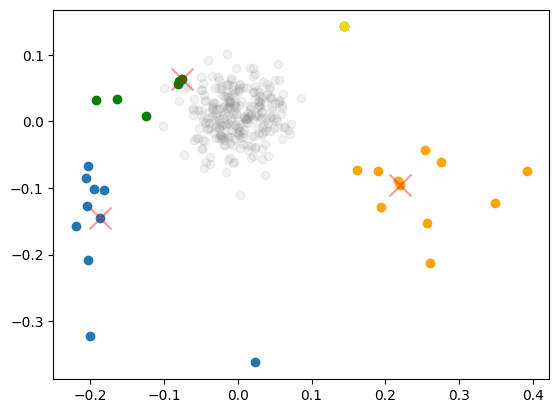

In [ ]:
# @title Visualize agent embeddings
agent_list = algo.config.policies

agent_list = list(filter(lambda x: '_v' in x, agent_list))
agent_list = sorted(agent_list, key=lambda x: int(x.split('_v')[-1]))

main_agents = list(filter(lambda x: 'main_v' in x, agent_list))
league_exploiters = list(filter(lambda x: 'league_exploiter_v' in x, agent_list))
main_exploiters = list(filter(lambda x: 'main_exploiter_v' in x, agent_list))

embeddings = algo.learner_group._learner._module[SHARED_CRITIC_ID].emb.weight.detach().clone().T

import numpy as np
from sklearn.decomposition import PCA
X = np.array(embeddings)
pca = PCA(n_components=2)
pca.fit(X)
proj = pca.transform(embeddings)

# Remember that ME and LE don't have a v0, and Main's V0 wasn't initialized from Main (nor was its embedding)
import matplotlib.pyplot as plt
plt.scatter(proj[:,0],proj[:,1], c='gray', alpha=0.1)
# Main agents
plt.scatter(proj[0:len(main_agents),0],proj[0:len(main_agents),1])
plt.scatter(proj[1,0],proj[1,1], color='gold')
# League Exploiters
plt.scatter(proj[100,0],proj[100,1], color='orange')
plt.scatter(proj[102:102+len(league_exploiters),0],proj[102:102+len(league_exploiters),1], color='orange')
# Main Exploiters
plt.scatter(proj[200,0],proj[200,1], color='green')
plt.scatter(proj[202:202+len(main_exploiters),0],proj[202:202+len(main_exploiters),1], color='green')
# Learned agents
plt.scatter(proj[[0,100,200],0],proj[[0,100,200],1], alpha=0.4, color='red', s=250, marker='x')

In [ ]:
# @title Visualize win rates
N = 200 # @param {"type":"integer","placeholder":"50"}
from torch.distributions import Categorical
learned_agent = algo.env_runner.module['main']

env = TicTacToe()
def query_agent(obs, agent):
  if (isinstance(agent, torch.nn.Module)): # Learned
    obs[OBSERVATIONS] = torch.tensor(obs[OBSERVATIONS])
    obs[ACTION_MASK] = torch.tensor(obs[ACTION_MASK])
    logits = agent.forward_inference({Columns.OBS: obs})['action_dist_inputs']
    probs = torch.nn.Softmax()(logits)
    action = Categorical(probs).sample()
    return action.item()
  else:
    action = agent.forward_inference({Columns.OBS: torch.tensor(obs[OBSERVATIONS]).unsqueeze(0)})['actions'][0]
    return int(action)

# Agent, opponent, agent is X/O, win/lose/draw
win_rates = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0))))

for a1i in range(len(agent_list)):
  agent_name = agent_list[a1i]
  agent = algo.env_runner.module[agent_name]
  print(f"Calculating win rates for {agent_name}")
  for a2i in range(a1i, len(agent_list)):
    opponent_name = agent_list[a2i]
    opponent = algo.env_runner.module[opponent_name]
    for play_as, play_against in [('X','O'), ('O','X')]:
      agents = {
          play_as: agent,
          play_against: opponent
      }
      wr_dict = win_rates[agent_name][opponent_name][play_as]
      wr_dict_r = win_rates[opponent_name][agent_name][play_against]
      for i in range(N):
        obs, _ = env.reset()
        done = False
        rewards = defaultdict(lambda: 0)
        while (not done):
          a = {}
          for k in obs.keys():
            a[k] = query_agent(obs[k], agents[k])
          obs, r, term, trunc, _ = env.step(a)
          # Render
          for k, r in r.items():
            rewards[k] += r
          done = term['__all__']
        wr_dict[np.sign(rewards[play_as])] += 1
        wr_dict_r[-np.sign(rewards[play_as])] += 1

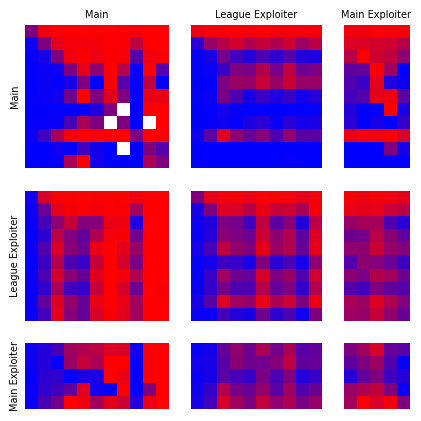

In [ ]:
# @title Generate visualization
import matplotlib.pyplot as plt
merge = True # @param {"type":"boolean"}
show_draws = False # @param {"type":"boolean"}
fontsize = 7 # @param {"type":"integer"}
cell_size = 0.14 # @param {"type":"number"} # inches per cell
left_label_space = 0.9
right_margin = 0.2
top_label_space = 0.6
bottom_margin = 0.2

# Agent, opponent, agent is X/O, win/lose/draw
def get_color(wld):
  if (wld[1]+wld[-1]==0):
    return [1,1,1]
  if (show_draws):
    colors = np.array([[0,0,1],[1,1,1],[1,0,0]])
    wlda = np.array([wld[1], wld[0], wld[-1]],dtype=float)
    if (wlda[0]+wlda[2]>0):
      wld_cap = 0.2
      wld_m = 1. / (1.-wlda[1]/wlda.sum()*(1-wld_cap))
      wlda[1] *= wld_cap
      wlda[[0,2]] *= wld_m
    wld = wlda
  else:
    colors = np.array([[0,0,1],[1,0,0]])
    wld = np.array([wld[1], wld[-1]])
  return (wld/wld.sum()) @ colors

groups = [
    ("Main", main_agents),
    ("League Exploiter", league_exploiters),
    ("Main Exploiter", main_exploiters),
]

def merge_data(wrab):
  tmp = wrab['X'].copy()
  for k in [1,0,-1]:
    tmp[k] += wrab['O'][k]
  return tmp

def build_color_array(row_agents, col_agents):
    rows, cols = len(row_agents), len(col_agents)
    arr = np.zeros((rows, cols, 3), dtype=float)
    for i, a in enumerate(row_agents):
        for j, b in enumerate(col_agents):
            if (merge):
              data = merge_data(win_rates[a][b])
            else:
              data = win_rates[a][b]['X']
            arr[i, j] = get_color(data)
    return arr

col_counts = [len(g[1]) for g in groups]
row_counts = [len(g[1]) for g in groups]

# figure size
fig_w = sum(col_counts) * cell_size + left_label_space + right_margin + 0.2  # extra margin for spacing
fig_h = sum(row_counts) * cell_size + top_label_space + bottom_margin + 0.2

left_frac = left_label_space / fig_w
right_frac = 1.0 - (right_margin / fig_w)
bottom_frac = bottom_margin / fig_h
top_frac = 1.0 - (top_label_space / fig_h)

fig = plt.figure(figsize=(fig_w, fig_h))

# add spacing here:
wspace = 0.2  # horizontal space between subplot blocks
hspace = 0.2  # vertical space between subplot blocks

gs = fig.add_gridspec(
    3, 3,
    width_ratios=col_counts,
    height_ratios=row_counts,
    left=left_frac, right=right_frac, bottom=bottom_frac, top=top_frac,
    wspace=wspace, hspace=hspace
)

axes = np.empty((3, 3), dtype=object)
for i, (row_name, row_group) in enumerate(groups):
    for j, (col_name, col_group) in enumerate(groups):
        ax = fig.add_subplot(gs[i, j])
        axes[i, j] = ax
        col_arr = build_color_array(row_group, col_group)
        if col_arr.size == 0:
            ax.axis("off")
            continue
        ax.imshow(col_arr, interpolation="nearest", aspect="equal", origin="upper")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

# column group names
for j, (col_name, _) in enumerate(groups):
    pos = axes[0, j].get_position()
    x_center = pos.x0 + pos.width / 2.0
    y_top = pos.y1 + 0.01
    if (not merge):
      col_name += ' (O)'
    fig.text(x_center, y_top, col_name, ha="center", va="bottom", fontsize=fontsize)

# row group names
for i, (row_name, _) in enumerate(groups):
    pos = axes[i, 0].get_position()
    y_center = pos.y0 + pos.height / 2.0
    x_left = pos.x0 - 0.01
    if (not merge):
      row_name += ' (X)'
    fig.text(x_left, y_center, row_name, ha="right", va="center", fontsize=fontsize, rotation="vertical")

plt.show()
